# this is to show how double transport affect rate performance, will produce Fig. 3,4,5.

In [9]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'Times New Roman','size'   : fs}
mpl.rc('font', **font)

In [11]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = "D:/OneDrive - Imperial College London/SimDataSave/P3R13/Paper/"  #'D:/OneDrive - Imperial College London/SimDataSave/P3R13/'; 
Target  = 'Rate_Performance_Finemesh_1EC1DMC/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [12]:
# define parameter of double and single 
Para_dict_Same = {
   ################################# Same for single and double:
   "Mesh list":[ [20,10,20,100,30], ],   # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   # solvent diffusion parameters:
   "EC initial concentration in electrolyte [mol.m-3]":[6250],
   "Typical EC concentration [mol.m-3]":[6250,],

   "Negative electrode porosity":[0.25],
   "SEI resistivity [Ohm.m]":[2e5,],
   "Initial inner SEI thickness [m]":[1.2362e-08,],
   "Initial outer SEI thickness [m]":[1.2362e-08,],
   "Contact resistance [Ohm]":[6e-3],
   "Cation transference number":[
    "electrolyte_transference_number_EC_DMC_1_1_Landesfeind2019_Con"],
   "Electrolyte conductivity [S.m-1]":[
    "electrolyte_conductivity_EC_DMC_1_1_Landesfeind2019_Con"],
   "Electrolyte diffusivity [m2.s-1]":[
    "electrolyte_diffusivity_EC_DMC_1_1_Landesfeind2019_Con"],
}

Para_dict_DD_ONLY = {
     "Model option":[{
      "SEI": "constant",
      "SEI porosity change": "true",
      #"SEI on cracks": "true",
      "solvent diffusion": "double spatial consume w refill",
      "electrolyte conductivity": "sol full"  ,
     "contact resistance":"true",  
      },],
     ################################# Need to be different between single and double:
     "EC Lithium ion cross diffusivity [m2.s-1]":[
        "Cross_diffusivity_1p5E_10","Cross_diffusivity_1p5E_12",], # 
     "EC diffusivity in electrolyte [m2.s-1]":[
        "EC_diffusivity_5E_10"],
     "EC transference number":[
        "EC_transference_number",],
     "Measured dLJP_dcEC": ["dLJP_Two_Species_dco_Jung2023",],
     "Measured dLJP_dce": ["dLJP_Two_Species_dce_Jung2023",],
}
Para_dict_SD_ONLY = {
     "Model option":[{
      "SEI": "constant",
      "SEI porosity change": "true",
      #"SEI on cracks": "true",
      "solvent diffusion": "single no consume wo refill",
      "electrolyte conductivity": "full"  ,
      "contact resistance":"true",
      },],
     ################################# fake, must have only one option
     "EC Lithium ion cross diffusivity [m2.s-1]":[
        "Cross_diffusivity_1p5E_10"],
     "EC diffusivity in electrolyte [m2.s-1]":[
        "EC_diffusivity_5E_10"],
     "EC transference number":[
        "EC_transference_number",],
     "Measured dLJP_dce":["dLJP_One_Specie_dce_Jung2023",]
}
Para_dict_DD = {**Para_dict_Same,**Para_dict_DD_ONLY}
Para_dict_SD = {**Para_dict_Same,**Para_dict_SD_ONLY}
Para_DD = [];  Para_SD=[];
recursive_scan(Para_DD,Para_dict_DD, list(Para_dict_DD.keys()), {})
recursive_scan(Para_SD,Para_dict_SD, list(Para_dict_SD.keys()), {})
print(len(Para_DD),len(Para_SD))

2 1


In [13]:
book_name_xlsx = 'Test.xlsx';sheet_name_xlsx = 'Results';
Path_Exp_Crate = "D:/OneDrive - Imperial College London/SimDataSave/InputData/Ruihe_newLGM50_Crate/"
Path_pack = [BasicPath,Target,Path_Exp_Crate,book_name_xlsx,sheet_name_xlsx,];

In [14]:
# Three set of solution:
Rate_Dis_All = [1,1.5, 2,2.25,2.5,2.6,2.7,2.8,2.9, 3, ]; 
DD_HDx_Crate = Scan_Crate_Paper(
    0.0, Para_DD[0], Path_pack , "DD_HDx",
    Rate_Dis_All,True,)


Start Now! Scan 0.


At t = 0.00623417, , mxstep steps taken before reaching tout.


Finish DD_HDx - Scan=0.0


In [15]:
DD_LDx_Crate = Scan_Crate_Paper(
    1.0, Para_DD[1], Path_pack , "DD_LDx",
    Rate_Dis_All,True,)
SD_Crate = Scan_Crate_Paper(
    2.0, Para_SD[0], Path_pack , "SD",
    Rate_Dis_All,True,)

Start Now! Scan 1.


At t = 0.0062825, , mxstep steps taken before reaching tout.


Finish DD_LDx - Scan=1.0
Start Now! Scan 2.


At t = 0.00622749, , mxstep steps taken before reaching tout.


Finish SD - Scan=2.0


In [16]:
# cyc based 
def Get_Vol_Component(DD_HDx_Crate):
    DD_HDx_Crate['Cyc Mean eta_c_e'] = []
    DD_HDx_Crate['Cyc Mean eta_c_EC'] = []
    DD_HDx_Crate['Cyc Mean eta_others'] = []
    DD_HDx_Crate['Cyc Mean eta_tot'] = []
    DD_HDx_Crate['Cyc Last eta_c_e'] = []
    DD_HDx_Crate['Cyc Last eta_c_EC'] = []
    DD_HDx_Crate['Cyc Last eta_others'] = []
    DD_HDx_Crate['Cyc Last eta_tot'] = []
    DD_HDx_Crate['Cyc Mean eta_c_e %'] = []
    DD_HDx_Crate['Cyc Mean eta_c_EC %'] = []
    DD_HDx_Crate['Cyc Mean eta_others %'] = []
    for sol in DD_HDx_Crate['Sol_All']:
        step_CD = sol.cycles[0].steps[1]
        ocv = step_CD["X-averaged battery open circuit voltage [V]"].entries
        eta_c_e = -step_CD[
            "X-averaged battery concentration overpotential [V]"].entries
        eta_c_EC = -step_CD[
            "X-averaged EC concentration overpotential [V]"].entries
        V = step_CD["Terminal voltage [V]"].entries
        eta_others = ocv - eta_c_e - eta_c_EC - V
        eta_tot = ocv - V
        mean_eta_c_e = np.mean(eta_c_e)
        mean_eta_c_EC = np.mean(eta_c_EC)
        mean_eta_others = np.mean(eta_others)
        mean_eta_c_tot = np.mean(eta_tot)
        DD_HDx_Crate['Cyc Mean eta_c_e'].append(np.mean(eta_c_e))
        DD_HDx_Crate['Cyc Mean eta_c_EC'].append(np.mean(eta_c_EC))
        DD_HDx_Crate['Cyc Mean eta_others'].append(np.mean(eta_others))
        DD_HDx_Crate['Cyc Mean eta_tot'].append(np.mean(eta_tot))
        DD_HDx_Crate['Cyc Last eta_c_e'].append(eta_c_e[-1])
        DD_HDx_Crate['Cyc Last eta_c_EC'].append(eta_c_EC[-1])
        DD_HDx_Crate['Cyc Last eta_others'].append(eta_others[-1])
        DD_HDx_Crate['Cyc Last eta_tot'].append(eta_tot[-1])
        DD_HDx_Crate['Cyc Mean eta_c_e %'].append(
            mean_eta_c_e/mean_eta_c_tot*100)
        DD_HDx_Crate['Cyc Mean eta_c_EC %'].append(
            mean_eta_c_EC/mean_eta_c_tot*100)
        DD_HDx_Crate['Cyc Mean eta_others %'].append(
            mean_eta_others/mean_eta_c_tot*100)
    return DD_HDx_Crate
DD_HDx_Crate = Get_Vol_Component(DD_HDx_Crate)
DD_LDx_Crate = Get_Vol_Component(DD_LDx_Crate)
SD_Crate     = Get_Vol_Component(SD_Crate)

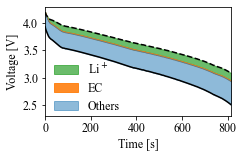

<Figure size 432x288 with 0 Axes>

In [28]:
# Fig. 3 - only overpotential, and three components:
def Plot_Voldecom_All(DD_HDx_Crate,Crate_index,SaveFig):
    #Crate_index = -1
    Colors_a = [
        [31/255, 119/255, 180/255, 0.5], # like blue
        [44/255, 160/255, 44/255,  0.7], # like green  
        [214/255, 39/255, 40/255,  0.7], # like red
        [255/255, 127/255, 14/255, 0.9],]# like orange 
    sol_dd_HDx = DD_HDx_Crate['Sol_All'][Crate_index]
    step_CD = sol_dd_HDx.cycles[0].steps[1]
    time = step_CD["Time [s]"].entries - step_CD["Time [s]"].entries[0] # 
    zeros = 0*np.ones_like(time)
    ocv = step_CD["X-averaged battery open circuit voltage [V]"].entries
    Total_overpotential = ocv - step_CD["Terminal voltage [V]"].entries;
    eta_c_e = -step_CD["X-averaged battery concentration overpotential [V]"].entries
    eta_c_EC = -step_CD["X-averaged EC concentration overpotential [V]"].entries
    V = step_CD["Terminal voltage [V]"].entries
    eta_others = ocv - eta_c_e - eta_c_EC - V
    eta_tot = ocv - V

    fs = 12; font = {'family' : 'Times New Roman','size'   : fs}
    mpl.rc('font', **font)
    fig, ax = plt.subplots(figsize=(9/2.54,6/2.54),tight_layout=True)
    ax.plot(time, ocv, "k--", ) # label="Open-circuit voltage"
    ax.fill_between(time, ocv-eta_c_e, ocv, color=Colors_a[1], label=r"Li$^+$")
    ax.fill_between(time, ocv-eta_c_e-eta_c_EC, ocv-eta_c_e, color=Colors_a[3],  label="EC")
    ax.fill_between(time, V, ocv-eta_c_e-eta_c_EC,  color=Colors_a[0],  label="Others")

    ax.plot(time, V, "k-", ) # label="Terminal voltage"

    leg = ax.legend(loc="lower left", bbox_to_anchor=(-0.01, -0.07),frameon=False)
    ax.set_xlim([time[0], time[-1]])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Voltage [V]")
    ax.set_ylim([2.3,4.3])
    plt.show()
    if SaveFig == True:
        plt.savefig(BasicPath + Target
            +f"{Rate_Dis_All[Crate_index]}C discharge voltage decomposition.png", 
            dpi=1000)
        plt.savefig(BasicPath + Target + 
            f'{Rate_Dis_All[Crate_index]}C discharge voltage decomposition.svg') 
#Plot_Voldecom_All(SD_Crate,-1,False)
#Plot_Voldecom_All(DD_LDx_Crate,-1,False)
Plot_Voldecom_All(DD_HDx_Crate,-1,  True)

Time selected is for 3C is 813.9999999999998 and 813.9999999999998,814.0 s


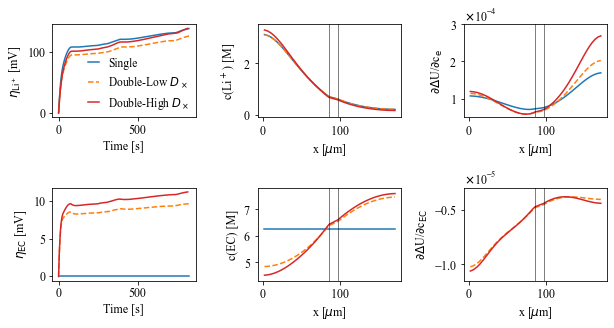

In [43]:
# Fig. 4 Concentration, LJP and overpotential 
def FindClose(time_DD,t_select): # Input must be a list
    for i in range(0,len(time_DD)):
        if abs(time_DD[i] - t_select)<1e-3:
            break
    return i
fs = 12
font = {'family' : 'Times New Roman','size'   : fs}
mpl.rc('font', **font)
x_loc = ["x [m]","x [m]","x [m]","x [m]","x [m]","x [m]"]
Str=[ 'DFN',   'Double trans' ]; # Str_model =[ 'Model_DFN',   'Model_DD' ]
Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
Labels = ["Single",r"Double-Low $D_\times$",r"Double-High $D_\times$"]
LS = ['-','--','-',];MS=['none','none','h']; ms = 8
Str=[ 'DFN',  'Double' ]
def Plot_Eta_c(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Ylim,Crate_index,SaveFig):
    fig, axs = plt.subplots(2,3, figsize=(22/2.53,12/2.54),tight_layout=True) #,
    step_sd = SD_Crate['Sol_All'][Crate_index].cycles[0].steps[1]
    step_DD_LDx = DD_LDx_Crate['Sol_All'][Crate_index].cycles[0].steps[1]
    step_DD_HDx = DD_HDx_Crate['Sol_All'][Crate_index].cycles[0].steps[1]
    Steps = [step_sd,step_DD_LDx,step_DD_HDx] 
    Labels = [r"Single",r"Double-Low $D_\times$",r"Double-High $D_\times$"]
    for k,step in enumerate(Steps):
        axs[0,0].plot(
            step['Time [s]'].entries-step['Time [s]'].entries[0], 
            -step["X-averaged battery concentration overpotential [V]"].entries*1e3,
            color=Colors[k],linestyle=LS[k],label=Labels[k]) 
        axs[1,0].plot(
            step['Time [s]'].entries-step['Time [s]'].entries[0], 
            -step["X-averaged battery EC concentration overpotential [V]"].entries*1e3,
            color=Colors[k],linestyle=LS[k],label=Labels[k]) 
    axs[0,0].set_ylabel("$\eta_{\mathrm{Li}^+}$ [mV]",fontsize=fs)
    #"$\partial\Delta$U/$\partial$c$_\mathrm{EC}$"
    axs[1,0].set_ylabel("$\eta_{\mathrm{EC}}$ [mV]",fontsize=fs)
    axs[1,0].set_xlabel("Time [s]",fontsize=fs)
    axs[0,0].set_xlabel("Time [s]",fontsize=fs)
    #fig.suptitle(f"EC and Li+ overpotential - {Rate_Dis_All[Crate_index]}C Discharge", fontsize=fs+1)
    var_elely = [
        "Electrolyte concentration [mol.m-3]",
        "dLJP_dce",
        "EC concentration [mol.m-3]",
        "dLJP_dcEC",] 
    Title_elely = [
        "c(Li+) [M]",
        "dLJP_dce",
        "c(EC) [M]",
        "dLJP_dcEC",]

    time_Single_High = (step_sd['Time [s]'].entries-step_sd['Time [s]'].entries[0]).tolist()
    time_Double_High = (step_DD_HDx['Time [s]'].entries-step_DD_HDx['Time [s]'].entries[0]).tolist()
    time_Double_Low  = (step_DD_LDx['Time [s]'].entries-step_DD_LDx['Time [s]'].entries[0]).tolist()

    t_select = min(time_Single_High[-2],time_Double_High[-2],time_Double_Low[-2])
    i_Single_High = FindClose(time_Single_High,t_select)
    i_Double_High = FindClose(time_Double_High,t_select)

    i_Double_Low = FindClose(time_Double_Low,t_select)

    print(f'Time selected is for {Rate_Dis_All[Crate_index]}C is {time_Single_High[i_Single_High]} and {time_Double_High[i_Double_High]},{time_Double_Low[i_Double_Low]} s')
    Y_0p = np.arange(-1,10,0.1)
    Index_MN = [ [0,1],[0,2],[1,1],[1,2]     ]
    for i in range(4):
        m,n = Index_MN[i]
        x_Single_High =   step_sd[x_loc[i]].entries[:,0]
        y_Single_High =   step_sd[var_elely[i]].entries[:,i_Single_High]

        x_Double_High =   step_DD_HDx[x_loc[i]].entries[:,0]
        y_Double_High =   step_DD_HDx[var_elely[i]].entries[:,i_Double_High]
        x_Double_Low  =   step_DD_LDx[x_loc[i]].entries[:,0]
        y_Double_Low  =   step_DD_LDx[var_elely[i]].entries[:,i_Double_Low]
        if var_elely[i].__contains__("[mol.m-3]"): 
            axs[m,n].plot(x_Single_High*1e6, y_Single_High/1e3, color=Colors[0],linestyle=LS[0],label=r"Single") 
            axs[m,n].plot(x_Double_Low*1e6, y_Double_Low/1e3, color=Colors[1],linestyle=LS[1],label=r"Double-Low D$_\times$") 
            axs[m,n].plot(x_Double_High*1e6, y_Double_High/1e3, color=Colors[2],linestyle=LS[2],label=r"Double-High D$_\times$") 
            axs[m,n].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
            axs[m,n].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)
        else:
            if var_elely[i] == "dLJP_dcEC": 
                pass
            else:
                axs[m,n].plot(x_Single_High*1e6, y_Single_High, color=Colors[0],linestyle=LS[0],label=r"Single") 
            axs[m,n].plot(x_Double_Low*1e6, y_Double_Low, color=Colors[1],linestyle=LS[1],label=r"Double-Low $D_\times$") 
            axs[m,n].plot(x_Double_High*1e6, y_Double_High, color=Colors[2],linestyle=LS[2],label=r"Double-High $D_\times$") 
            axs[m,n].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
            axs[m,n].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)

        axs[m,n].set_xlabel(r"x [$\mu$m]",   fontdict={'family':'Times New Roman','size':fs})
        #axs[m,n].set_title(Title_elely[i]) 
        axs[m,n].ticklabel_format( 
            axis='x', style='sci',
            scilimits=[-1e2,1e2], useOffset=None, 
            useLocale=None, useMathText=True)
        axs[m,n].ticklabel_format( 
            axis='y', style='sci',
            scilimits=[-1e-2,1e-2], useOffset=None, 
            useLocale=None, useMathText=True)
    axs[0,1].set_ylabel("c(Li$^+$) [M]");axs[1,1].set_ylabel("c(EC) [M]")
    axs[0,2].set_ylabel("$\partial\Delta$U/$\partial$c$_\mathrm{e}$");  
    axs[1,2].set_ylabel("$\partial\Delta$U/$\partial$c$_\mathrm{EC}$")

    axs[0,1].set_ylim(Ylim[0])
    axs[0,2].set_ylim(Ylim[1])
    axs[1,1].set_ylim(Ylim[2])
    axs[1,2].set_ylim(Ylim[3])
    fig.subplots_adjust(wspace=0, hspace=0)
    axs[0,0].legend(prop={'family':'Times New Roman','size':fs-0.5},
        loc='lower right',ncol=1,  bbox_to_anchor=(1, -0.00),
        frameon=False,markerscale=0.5,borderpad=0.0,
        handlelength=1.0,columnspacing=1)
    if SaveFig == True:
        plt.savefig(BasicPath + Target
                +f"Fig_4_{Rate_Dis_All[Crate_index]}C Overpotential and concentration.png", dpi=1000)
        plt.savefig(BasicPath + Target + 
                f"Fig_4_{Rate_Dis_All[Crate_index]}C Overpotential and concentration.svg") 
Ylim = [[-0.1,3.5],[0.5e-4,3.0e-4],[4.3,7.8],[-1.15e-5,-0.3e-5]]
fs = 12;font = {'family' : 'Times New Roman','size': fs}
mpl.rc('font', **font)
LS = ['-','--','-',]; 
Plot_Eta_c(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Ylim,Crate_index=-1,SaveFig=True)
#Plot_Eta_c(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Ylim,Crate_index=0,SaveFig=False)

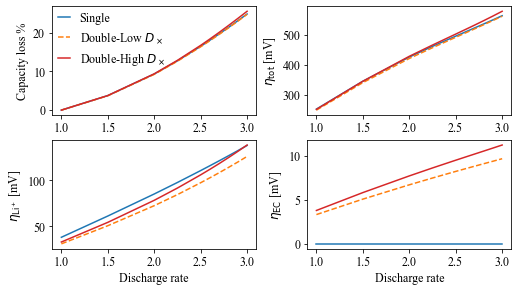

In [19]:
# Fig. 5 - Plot summary and overpotential 
def Plot_Summary_VolCom_Last(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,SaveFig):
    fig, axs = plt.subplots(2,2 , figsize=(18/2.54,10/2.54),layout='constrained') #
    Cases = [SD_Crate,DD_LDx_Crate,DD_HDx_Crate]
    for k,case in enumerate(Cases):
            y_temp = case['Cap_Dis_All']; 
            y_plt = (1 - y_temp / y_temp[0])*100
            axs[0,0].plot(
                Rate_Dis_All,y_plt,color=Colors[k],
                linestyle=LS[k],label=Labels[k]) 
            axs[0,1].plot(
                Rate_Dis_All,np.array(case['Cyc Last eta_tot'])*1e3,
                color=Colors[k],linestyle=LS[k],label=Labels[k]) 
            axs[1,0].plot(
                Rate_Dis_All,np.array(case['Cyc Last eta_c_e'])*1e3,
                color=Colors[k],linestyle=LS[k],label=Labels[k]) 
            axs[1,1].plot(
                Rate_Dis_All,np.array(case['Cyc Last eta_c_EC'])*1e3,
                color=Colors[k],linestyle=LS[k],label=Labels[k]) 
    axs[0,0].set_ylabel("Capacity loss %")
    axs[0,1].set_ylabel("$\eta_{\mathrm{tot}}$ [mV]",fontsize=fs)
    axs[1,0].set_ylabel("$\eta_{\mathrm{Li^+}}$ [mV]",fontsize=fs)
    axs[1,1].set_ylabel("$\eta_{\mathrm{EC}}$ [mV]",fontsize=fs)
    for k in range(2):
         axs[1,k].set_xlabel("Discharge rate")
    axs[0,0].legend(prop={'family':'Times New Roman','size':fs},
        loc='best',ncol=1,  #bbox_to_anchor=(1, -0.00),
        frameon=False,markerscale=0.5,borderpad=0.0,
        handlelength=1.0,columnspacing=1)
    if SaveFig == True:
        plt.savefig(BasicPath +  Target+ 
            f"Fig_5_Summary Elely Overpotential last.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ 
            f"Fig_5_Elely Overpotential last.svg")  
fs = 12
font = {'family' : 'Times New Roman','size'   : fs}
mpl.rc('font', **font)
Str=[ 'DFN',   'Double trans' ]; # Str_model =[ 'Model_DFN',   'Model_DD' ]
Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
Labels = ["Single",r"Double-Low $D_\times$",r"Double-High $D_\times$"]
LS = ['-','--','-',];MS=['none','none','h']; ms = 8
Plot_Summary_VolCom_Last(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,SaveFig=True)

In [49]:
DD_HDx_Crate['Sol_All'][0]

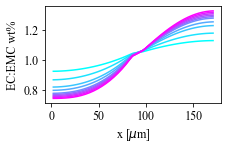

In [52]:
# Plot EC:DMC wt%
def Plot_EC_DMC_Crate(DD_HDx_Crate,SaveFig):
    cm = mpl.cm.get_cmap("cool", len(DD_HDx_Crate['Sol_All'])) 

    Y_0p = np.arange(-1,10,0.1)
    fig, axs = plt.subplots( figsize=(8/2.54,4.5/2.54), ) #tight_layout=True
    for i,sol_Double_High in enumerate(DD_HDx_Crate['Sol_All']):
        step_i  =sol_Double_High.cycles[0].steps[1]
        t_i = (step_i['Time [s]'].entries-step_i['Time [s]'].entries[0]).tolist()
        x_Double_High =   step_i["x [m]"].entries[:,0]
        y_Double_High =   step_i["EC:EMC wt%"].entries[:,-1]
        axs.plot(x_Double_High*1e6, y_Double_High, 
                 color=cm(i),linestyle=LS[0],
                 label=r"Double-High D$_\times$") 

        axs.set_xlabel(r"x [$\mu$m]",fontdict={'family':'Times New Roman','size':fs})
        #axs.set_title(Title_keys[i]) 
        axs.ticklabel_format( 
            axis='x', style='sci',
            scilimits=[-1e3,1e3], useOffset=None, 
            useLocale=None, useMathText=None)
    axs.set_ylabel("EC:EMC wt%")
    #axs.legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
    #axs[0].set_ylim([-0.1,4.1])
    #axs[1].set_ylim([1.7,4.8])
    #axs[2].set_ylim([5.5,7.6])
    # fig.suptitle(f"3C Discharge, t={round(t_select)} s", fontsize=fs+1)
    if SaveFig == True:
        plt.savefig(BasicPath +  Target+ f"c.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ f"EC:EMC wt%.svg")  

Plot_EC_DMC_Crate(DD_HDx_Crate,SaveFig=False)


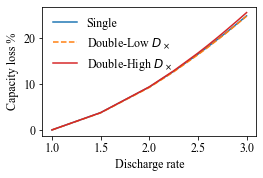

In [44]:
# plot the effect of charge / discharge rate and Dx
fs = 12
font = {'family' : 'Times New Roman','size'   : fs}
mpl.rc('font', **font)
Str=[ 'DFN',   'Double trans' ]; # Str_model =[ 'Model_DFN',   'Model_DD' ]

Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
Labels = ["Single",r"Double-Low $D_\times$",r"Double-High $D_\times$"]
LS = ['-','--','-',];MS=['none','none','h']; ms = 8

def Plot_Summary(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,SaveFig):
        fig, axs = plt.subplots( figsize=(9/2.54,6/2.54), layout='constrained')
        Cases = [SD_Crate,DD_LDx_Crate,DD_HDx_Crate]
        for k,case in enumerate(Cases):
                y_temp = case['Cap_Dis_All']; 
                y_plt = (1 - y_temp / y_temp[0])*100
                axs.plot(
                        Rate_Dis_All,y_plt,color=Colors[k],
                        linestyle=LS[k],label=Labels[k]) 
        axs.set_ylabel("Capacity loss %")
        axs.set_xlabel("Discharge rate")
        axs.set_xlabel("Discharge rate")
        #axs.set_ylim(3.9,5.1);   # axs[1].set_ylim(3.9,5.1)

        #axs[0].set_title(r"$D_\times=1.5\bullet10^{-12}  m^2/s$", fontdict={'family':'Times New Roman','size':fs})
        #axs[1].set_title(r"$D_\times=1.5\bullet10^{-10}  m^2/s$", fontdict={'family':'Times New Roman','size':fs})
        axs.legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False,)
        #axs.legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False,)
        if SaveFig == True:
                plt.savefig(
                        BasicPath + Target+"Fig_3-Summary Crate.png", dpi=1000)
                plt.savefig(BasicPath + Target + 
                        f'Fig_3-Summary Crate.svg') 
Plot_Summary(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,SaveFig=True)

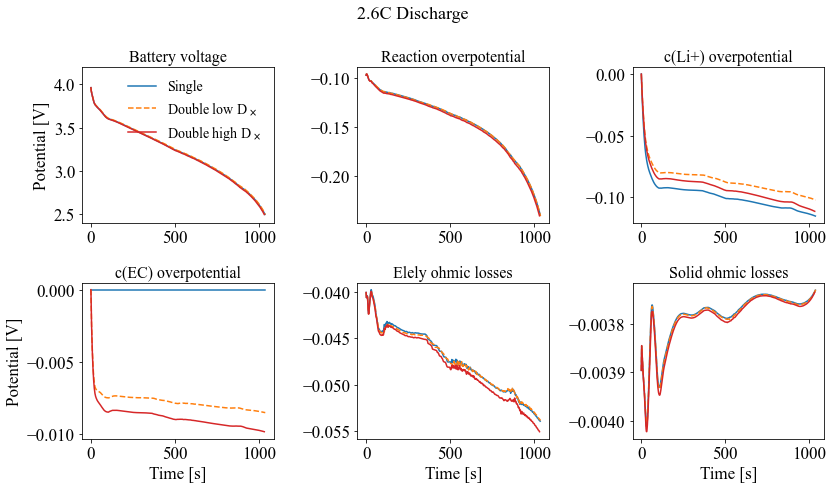

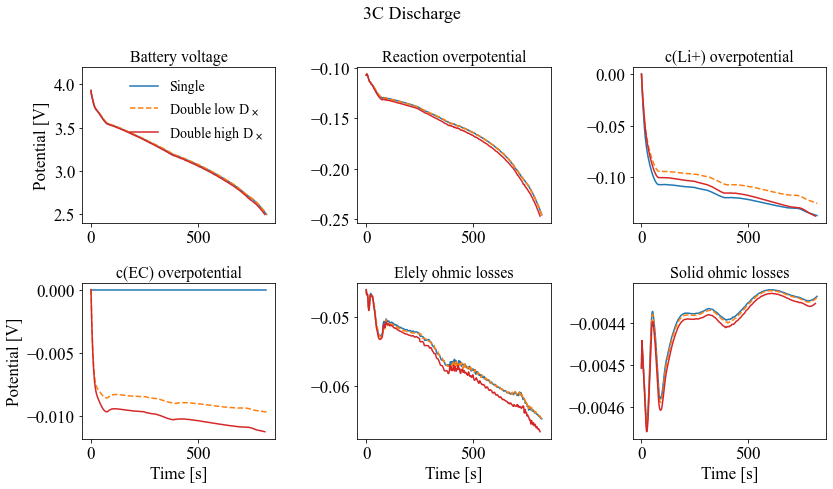

In [21]:
# plot voltage stuff:
fs = 17
font = {'family' : 'Times New Roman','size'   : fs}
mpl.rc('font', **font)
LS = ['-','--','-',];
def Plot_Voldecom_All(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Crate_index,SaveFig):
    # Crate_index = -1
    sol_sd = SD_Crate['Sol_All'][Crate_index]
    sol_dd_HDx = DD_HDx_Crate['Sol_All'][Crate_index]
    sol_dd_LDx = DD_LDx_Crate['Sol_All'][Crate_index]
    Sol_All = [sol_sd,sol_dd_LDx,sol_dd_HDx,];
    Str = ["Single",r"Double low D$_\times$",r"Double high D$_\times$"]
    fig, axs = plt.subplots(2,3, figsize=(12,7),tight_layout=True)
    Keys_t_var = [
        "Battery voltage [V]",
        "X-averaged battery reaction overpotential [V]",
        "X-averaged battery concentration overpotential [V]",
        "X-averaged EC concentration overpotential [V]", # Mark Ruihe add
        "X-averaged battery electrolyte ohmic losses [V]",
        "X-averaged battery solid phase ohmic losses [V]",
    ]
    Title_keys = [
        "Battery voltage",
        "Reaction overpotential",
        "c(Li+) overpotential",
        "c(EC) overpotential",
        "Elely ohmic losses",
        "Solid ohmic losses"
    ]
    for k,sol in enumerate(Sol_All):
        time_1 = sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0]
        for i in range(0,6): # 0 1 2 3 4 5 --> [0,0] [0,1], [0,2], [1,0], [1,1], [1,2]   
            var =  sol.cycles[0].steps[1][Keys_t_var[i]].entries
            if i < 3:
                m=0; n =i
            else:
                m=1; n=i-3
            axs[m,n].plot(time_1, var,color=Colors[k],linestyle=LS[k],label=Str[k]) # label="1st cycle"
            axs[m,n].set_title(Title_keys[i],fontdict={'family':'Times New Roman','size':fs-1})
            
            axs[1,n].set_xlabel('Time [s]',   fontdict={'family':'Times New Roman','size':fs})
            fig.suptitle(f"{Rate_Dis_All[Crate_index]}C Discharge", fontsize=fs+1)
            
            labels = axs[m,n].get_xticklabels() + axs[m,n].get_yticklabels(); 
            axs[0,0].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
        axs[0,0].set_ylim(2.4,4.2)
    axs[0,0].set_ylabel("Potential [V]",   fontdict={'family':'Times New Roman','size':fs})
    axs[1,0].set_ylabel("Potential [V]",   fontdict={'family':'Times New Roman','size':fs})
    if SaveFig == True:
        plt.savefig(BasicPath + Target
                +f"{Rate_Dis_All[Crate_index]}C Vol decom all.png", dpi=1000)
        plt.savefig(BasicPath + Target + 
                f"{Rate_Dis_All[Crate_index]}C Vol decom all.svg") 
Plot_Voldecom_All(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,5,SaveFig=False)
Plot_Voldecom_All(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,-1,SaveFig=False)

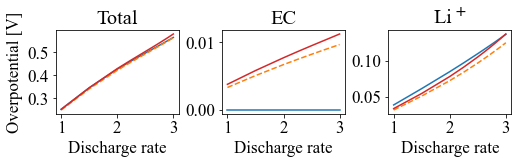

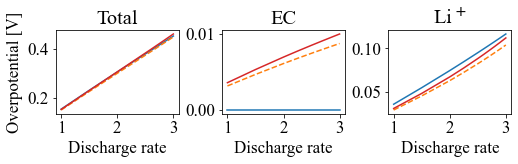

In [22]:
Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e'];
LS = ['-','--','-',];MS=['none','none','h']; ms = 8
def Plot_Voldecom_mean_Eley(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,SaveFig):
    fig, axs = plt.subplots(1,3 , figsize=(18/2.54,5.5/2.54),layout='constrained') #
    axs[0].plot(Rate_Dis_All,SD_Crate['Cyc Mean eta_tot'],
                color=Colors[0],linestyle=LS[0],label=r"Single") # marker = MS[1],markerfacecolor='w',markersize = ms,
    axs[1].plot(Rate_Dis_All,SD_Crate['Cyc Mean eta_c_EC'],
                color=Colors[0],linestyle=LS[0],label=r"Single")
    axs[2].plot(Rate_Dis_All,SD_Crate['Cyc Mean eta_c_e'],
                color=Colors[0],linestyle=LS[0],label=r"Single")

    axs[0].plot(Rate_Dis_All,DD_LDx_Crate['Cyc Mean eta_tot'],
                color=Colors[3],linestyle=LS[1], label=r"Double low D$_\times$")
    axs[1].plot(Rate_Dis_All,DD_LDx_Crate['Cyc Mean eta_c_EC'],
        color=Colors[3],linestyle=LS[1],label=r"Double low D$_\times$")
    axs[2].plot(Rate_Dis_All,DD_LDx_Crate['Cyc Mean eta_c_e'],
        color=Colors[3],linestyle=LS[1],label=r"Double low D$_\times$")

    axs[0].plot(Rate_Dis_All,DD_HDx_Crate['Cyc Mean eta_tot'],
                color=Colors[2],linestyle=LS[2], label=r"Double high D$_\times$")
    axs[1].plot(Rate_Dis_All,DD_HDx_Crate['Cyc Mean eta_c_EC'],
        color=Colors[2],linestyle=LS[2],label=r"Double high D$_\times$")
    axs[2].plot(Rate_Dis_All,DD_HDx_Crate['Cyc Mean eta_c_e'],
        color=Colors[2],linestyle=LS[2],label=r"Double high D$_\times$")
    axs[0].set_ylabel("Overpotential [V]")
    axs[0].set_xlabel("Discharge rate")
    axs[1].set_xlabel("Discharge rate")
    axs[2].set_xlabel("Discharge rate")
    axs[0].set_title("Total") 
    axs[1].set_title("EC") 
    axs[2].set_title(r"Li$^+$") 
    if SaveFig == True:
        plt.savefig(BasicPath +  Target+ 
            f"Elely Overpotential mean.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ 
            f"Elely Overpotential mean.svg")  
def Plot_Voldecom_last_Eley(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,SaveFig):
    fig, axs = plt.subplots(1,3 , figsize=(18/2.54,5.5/2.54),layout='constrained') #
    Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e'];
    LS = ['-','--','-',];MS=['none','none','h']; ms = 8

    axs[0].plot(Rate_Dis_All,SD_Crate['Cyc Last eta_tot'],
                color=Colors[0],linestyle=LS[0],label=r"Single") # marker = MS[1],markerfacecolor='w',markersize = ms,
    axs[1].plot(Rate_Dis_All,SD_Crate['Cyc Last eta_c_EC'],
                color=Colors[0],linestyle=LS[0],label=r"Single")
    axs[2].plot(Rate_Dis_All,SD_Crate['Cyc Last eta_c_e'],
                color=Colors[0],linestyle=LS[0],label=r"Single")

    axs[0].plot(Rate_Dis_All,DD_LDx_Crate['Cyc Last eta_tot'],
                color=Colors[3],linestyle=LS[1], label=r"Double low D$_\times$")
    axs[1].plot(Rate_Dis_All,DD_LDx_Crate['Cyc Last eta_c_EC'],
        color=Colors[3],linestyle=LS[1],label=r"Double low D$_\times$")
    axs[2].plot(Rate_Dis_All,DD_LDx_Crate['Cyc Last eta_c_e'],
        color=Colors[3],linestyle=LS[1],label=r"Double low D$_\times$")

    axs[0].plot(Rate_Dis_All,DD_HDx_Crate['Cyc Last eta_tot'],
                color=Colors[2],linestyle=LS[2], label=r"Double high D$_\times$")
    axs[1].plot(Rate_Dis_All,DD_HDx_Crate['Cyc Last eta_c_EC'],
        color=Colors[2],linestyle=LS[2],label=r"Double high D$_\times$")
    axs[2].plot(Rate_Dis_All,DD_HDx_Crate['Cyc Last eta_c_e'],
        color=Colors[2],linestyle=LS[2],label=r"Double high D$_\times$")
    axs[0].set_ylabel("Overpotential [V]")
    axs[0].set_xlabel("Discharge rate")
    axs[1].set_xlabel("Discharge rate")
    axs[2].set_xlabel("Discharge rate")
    axs[0].set_title("Total") 
    axs[1].set_title("EC") 
    axs[2].set_title(r"Li$^+$") 
    if SaveFig == True:
        plt.savefig(BasicPath +  Target+ 
            f"Elely Overpotential last.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ 
            f"Elely Overpotential last.svg")  
Plot_Voldecom_last_Eley(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,SaveFig=False)
Plot_Voldecom_mean_Eley(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,SaveFig=False)

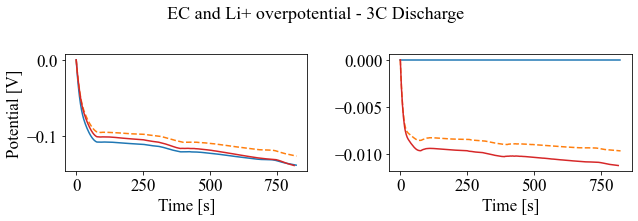

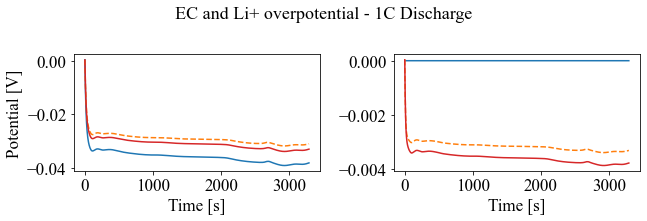

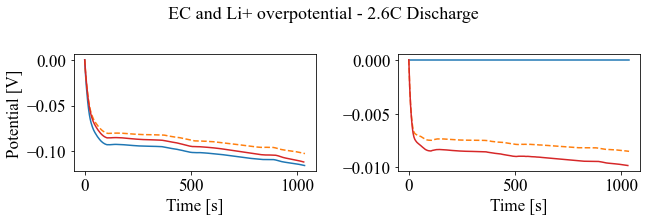

In [23]:
# old version - 3C rate: to plot only c_EC and c_Li+
LS = ['-','--','-','--'];
def Plot_Voldecom_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Crate_index,SaveFig):
    fig, axs = plt.subplots(1,2, figsize=(9.3,3.2),tight_layout=True)
    sol = SD_Crate['Sol_All'][Crate_index]
    axs[0].plot(
        sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0], 
        sol.cycles[0].steps[1]["X-averaged battery concentration overpotential [V]"].entries,
        color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 
    axs[1].plot(
        sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0], 
        sol.cycles[0].steps[1]["X-averaged EC concentration overpotential [V]"].entries,
        color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 

    sol = DD_LDx_Crate['Sol_All'][Crate_index]
    axs[0].plot(
        sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0], 
        sol.cycles[0].steps[1]["X-averaged battery concentration overpotential [V]"].entries,
        color=Colors[3],linestyle=LS[3],label=r"Double-Low $D_\times$") 
    axs[1].plot(
        sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0], 
        sol.cycles[0].steps[1]["X-averaged EC concentration overpotential [V]"].entries,
        color=Colors[3],linestyle=LS[3],label=r"Double-Low $D_\times$") 

    sol = DD_HDx_Crate['Sol_All'][Crate_index]
    axs[0].plot(
        sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0], 
        sol.cycles[0].steps[1]["X-averaged battery concentration overpotential [V]"].entries,
        color=Colors[2],linestyle=LS[2],label=r"Double-High $D_\times$") 
    axs[1].plot(
        sol.cycles[0].steps[1]['Time [s]'].entries-sol.cycles[0].steps[1]['Time [s]'].entries[0], 
        sol.cycles[0].steps[1]["X-averaged EC concentration overpotential [V]"].entries,
        color=Colors[2],linestyle=LS[2],label=r"Double-High $D_\times$") 

    axs[0].set_ylabel("Potential [V]",fontsize=fs)
    axs[1].set_xlabel("Time [s]",fontsize=fs)
    axs[0].set_xlabel("Time [s]",fontsize=fs)
    fig.suptitle(f"EC and Li+ overpotential - {Rate_Dis_All[Crate_index]}C Discharge", fontsize=fs+1)
    if SaveFig == True:
        plt.savefig(BasicPath +  Target+ 
            f"EC and Li+ Overpotential {Rate_Dis_All[Crate_index]}C discharge.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ 
            f"EC and Li+ Overpotential {Rate_Dis_All[Crate_index]}C discharge.svg")  
Plot_Voldecom_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Crate_index=-1,SaveFig=False)
Plot_Voldecom_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Crate_index=0,SaveFig=False)
Plot_Voldecom_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,Crate_index=5,SaveFig=False)

Time selected is for 2.6C is 1029.961853264694 and 1029.961853264694,1029.9618532646937 s
Time selected is for 2.6C is 1029.961853264694 and 1029.961853264694,1029.9618532646937 s
Time selected is for 1C is 3285.9999999999995 and 3286.0,3285.999999999999 s


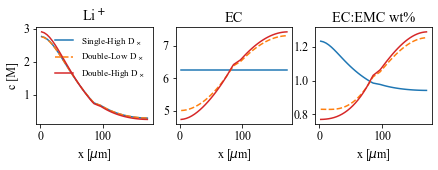

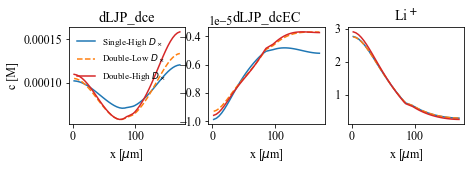

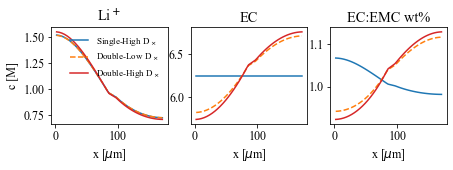

In [47]:
# compare conccnetration
def Plot_Concentration_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,
    x_loc,var_elely,Title_keys,Crate_index,SaveFig):
    sol_Single_High =  SD_Crate['Sol_All'][Crate_index]
    time_Single_High = (sol_Single_High.cycles[0].steps[1]['Time [s]'].entries-sol_Single_High.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()
    sol_Double_High = DD_HDx_Crate['Sol_All'][Crate_index]
    time_Double_High = (sol_Double_High.cycles[0].steps[1]['Time [s]'].entries-sol_Double_High.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()
    sol_Double_Low = DD_LDx_Crate['Sol_All'][Crate_index]
    time_Double_Low = (sol_Double_Low.cycles[0].steps[1]['Time [s]'].entries-sol_Double_Low.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()

    t_select = min(time_Single_High[-2],time_Double_High[-2],time_Double_Low[-2])
    i_Single_High = FindClose(time_Single_High,t_select)
    i_Double_High = FindClose(time_Double_High,t_select)

    i_Double_Low = FindClose(time_Double_Low,t_select)

    print(f'Time selected is for {Rate_Dis_All[Crate_index]}C is {time_Single_High[i_Single_High]} and {time_Double_High[i_Double_High]},{time_Double_Low[i_Double_Low]} s')
    Y_0p = np.arange(-1,10,0.1)
    fig, axs = plt.subplots(1,3, figsize=(18/2.54,4.5/2.54), ) #tight_layout=True
    for i in range(3):
        x_Single_High =   sol_Single_High.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_Single_High =   sol_Single_High.cycles[0].steps[1][var_elely[i]].entries[:,i_Single_High]

        x_Double_High =   sol_Double_High.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_Double_High =   sol_Double_High.cycles[0].steps[1][var_elely[i]].entries[:,i_Double_High]
        x_Double_Low =   sol_Double_Low.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_Double_Low =   sol_Double_Low.cycles[0].steps[1][var_elely[i]].entries[:,i_Double_Low]
        if var_elely[i].__contains__("[mol.m-3]"): 
            axs[i].plot(x_Single_High*1e6, y_Single_High/1e3, color=Colors[0],linestyle=LS[0],label=r"Single-High D$_\times$") 
            axs[i].plot(x_Double_Low*1e6, y_Double_Low/1e3, color=Colors[1],linestyle=LS[1],label=r"Double-Low D$_\times$") 
            axs[i].plot(x_Double_High*1e6, y_Double_High/1e3, color=Colors[2],linestyle=LS[0],label=r"Double-High D$_\times$") 
            #axs[i].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
            #axs[i].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)
        else:
            axs[i].plot(x_Single_High*1e6, y_Single_High, color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 
            axs[i].plot(x_Double_Low*1e6, y_Double_Low, color=Colors[1],linestyle=LS[1],label=r"Double-Low $D_\times$") 
            axs[i].plot(x_Double_High*1e6, y_Double_High, color=Colors[2],linestyle=LS[0],label=r"Double-High $D_\times$") 

        axs[i].set_xlabel(r"x [$\mu$m]",   fontdict={'family':'Times New Roman','size':fs})
        axs[i].set_title(Title_keys[i]) 
        axs[i].ticklabel_format( 
            axis='x', style='sci',
            scilimits=[-1e3,1e3], useOffset=None, 
            useLocale=None, useMathText=None)
    axs[0].set_ylabel("c [M]")
    axs[0].legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)  
    #axs[0].set_ylim([-0.1,4.1])
    #axs[1].set_ylim([1.7,4.8])
    #axs[2].set_ylim([5.5,7.6])
    # fig.suptitle(f"3C Discharge, t={round(t_select)} s", fontsize=fs+1)
    if SaveFig == True:
        plt.savefig(BasicPath +  Target+ 
            f"{Rate_Dis_All[Crate_index]}C Discharge, t={round(t_select)} s concentration profile.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ 
            f"{Rate_Dis_All[Crate_index]}C Discharge, t={round(t_select)} s concentration profile.svg")  
x_loc = ["x [m]","x [m]","x [m]","x [m]","x [m]","x [m]"]
var_elely = [
    "Electrolyte concentration [mol.m-3]",
    "EC concentration [mol.m-3]",
    "EC:EMC wt%",]  # "c(EMC) [mol.m-3]",] 
var_LJP = [
    "dLJP_dce",
    "dLJP_dcEC",
    "Electrolyte concentration [mol.m-3]",] 
Title_LJP = [
    "dLJP_dce",
    "dLJP_dcEC",
    r"Li$^+$",]
Title_keys = [
    r"Li$^+$",
    "EC",
    "EC:EMC wt%",]
Plot_Concentration_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,
    x_loc,var_elely,Title_keys,Crate_index=5,SaveFig=False)
Plot_Concentration_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,
    x_loc,var_LJP,Title_LJP,Crate_index=5,SaveFig=False)
Plot_Concentration_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,
    x_loc,var_elely,Title_keys,Crate_index=0,SaveFig=False)

Time selected is for 3C is 813.9999999999998 and 813.9999999999998,814.0 s


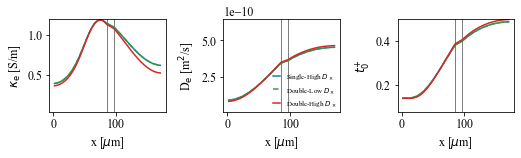

In [25]:
# compare electrolyte properties
fs = 12
font = {'family' : 'Times New Roman','size'   : fs}
mpl.rc('font', **font)

def Plot_EleyPro_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,
    x_loc,var_elely,Title_keys,Crate_index,SaveFig):

    sol_Single_High =  SD_Crate['Sol_All'][Crate_index]
    time_Single_High = (sol_Single_High.cycles[0].steps[1]['Time [s]'].entries-sol_Single_High.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()
    sol_Double_High = DD_HDx_Crate['Sol_All'][Crate_index]
    time_Double_High = (sol_Double_High.cycles[0].steps[1]['Time [s]'].entries-sol_Double_High.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()
    sol_Double_Low = DD_LDx_Crate['Sol_All'][Crate_index]
    time_Double_Low = (sol_Double_Low.cycles[0].steps[1]['Time [s]'].entries-sol_Double_Low.cycles[0].steps[1]['Time [s]'].entries[0]).tolist()

    t_select = min(time_Single_High[-2],time_Double_High[-2],time_Double_Low[-2])
    i_Single_High = FindClose(time_Single_High,t_select)
    i_Double_High = FindClose(time_Double_High,t_select)

    i_Double_Low = FindClose(time_Double_Low,t_select)

    print(f'Time selected is for {Rate_Dis_All[Crate_index]}C is {time_Single_High[i_Single_High]} and {time_Double_High[i_Double_High]},{time_Double_Low[i_Double_Low]} s')
    
    Y_0p = np.arange(-1e-10,3,1e-1)
    fig, axs = plt.subplots(1,3, figsize=(19/2.54,6/2.54),tight_layout=True) # 
    for i in range(3):
        x_Single_High =   sol_Single_High.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_Single_High =   sol_Single_High.cycles[0].steps[1][var_elely[i]].entries[:,i_Single_High]

        x_Double_High =   sol_Double_High.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_Double_High =   sol_Double_High.cycles[0].steps[1][var_elely[i]].entries[:,i_Double_High]
        x_Double_Low =   sol_Double_Low.cycles[0].steps[1][x_loc[i]].entries[:,0]
        y_Double_Low =   sol_Double_Low.cycles[0].steps[1][var_elely[i]].entries[:,i_Double_Low]
        axs[i].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
        axs[i].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)
        axs[i].plot(x_Single_High*1e6, y_Single_High, color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 
        axs[i].plot(x_Double_Low*1e6, y_Double_Low, color=Colors[1],linestyle=LS[1],label=r"Double-Low $D_\times$") 
        axs[i].plot(x_Double_High*1e6, y_Double_High, color=Colors[2],linestyle=LS[0],label=r"Double-High $D_\times$") 
        axs[i].set_xlabel(r"x [$\mu$m]",   fontdict={'family':'Times New Roman','size':fs})
        #axs[i].set_title(Title_keys[i]) 
        axs[i].ticklabel_format( 
            axis='x', style='sci',
            scilimits=[-1e3,1e3], useOffset=None, 
            useLocale=None, useMathText=None)
    axs[0].set_ylabel("$\kappa_\mathrm{e}$ [S/m]")
    axs[1].set_ylabel("D$_\mathrm{e}$ [m$^\mathrm{2}$/s]") # 
    axs[2].set_ylabel("$\mathit{t}_\mathrm{0}^\mathrm{+}$")
    axs[1].legend(prop={'family':'Times New Roman','size':fs-5},
        loc='best',ncol=1,  #bbox_to_anchor=(1, -0.00),
        frameon=False,markerscale=0.5,borderpad=0.0,
        handlelength=1.0,columnspacing=1)
    axs[0].set_ylim([0.05,1.2])
    axs[1].set_ylim([1e-11,6.5e-10])
    axs[2].set_ylim([0.08,0.5])
    if SaveFig == True:
        plt.savefig(BasicPath +  Target+ 
            f"Fig_S2_{Rate_Dis_All[Crate_index]}C Discharge, t={round(t_select)} s electrolyte properties.png", dpi=1000)
        plt.savefig(BasicPath +  Target+ 
            f"Fig_S2_{Rate_Dis_All[Crate_index]}C Discharge, t={round(t_select)} s electrolyte properties.svg") 

x_loc = ["x [m]","x [m]","x [m]","x [m]","x [m]","x [m]"]
var_elely = [
    "Electrolyte conductivity [S.m-1]",
    "Electrolyte diffusivity [m2.s-1]",
    "Cation transference number",]
Title_keys = [
    r"Li$^+$",
    "EC",
    "EMC",]
Plot_EleyPro_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,
    x_loc,var_elely,Title_keys,Crate_index=-1,SaveFig=False)
#Plot_EleyPro_1_Crate(SD_Crate,DD_LDx_Crate,DD_HDx_Crate,x_loc,var_elely,Title_keys,Crate_index=0,SaveFig=False)
